# Recurrent Neural Networks (RNNs)

If the data has some inherent sequential properties (e.g. time series or textual data), we can try using Recurrent neural networks. A Recurrent Neural Network goes through the elements in the sequences one by one and updates its internal hidden state in a loop.

A simple example is reading a sequence word by word (or character by character): as we go through the sentence we can understand more and more.

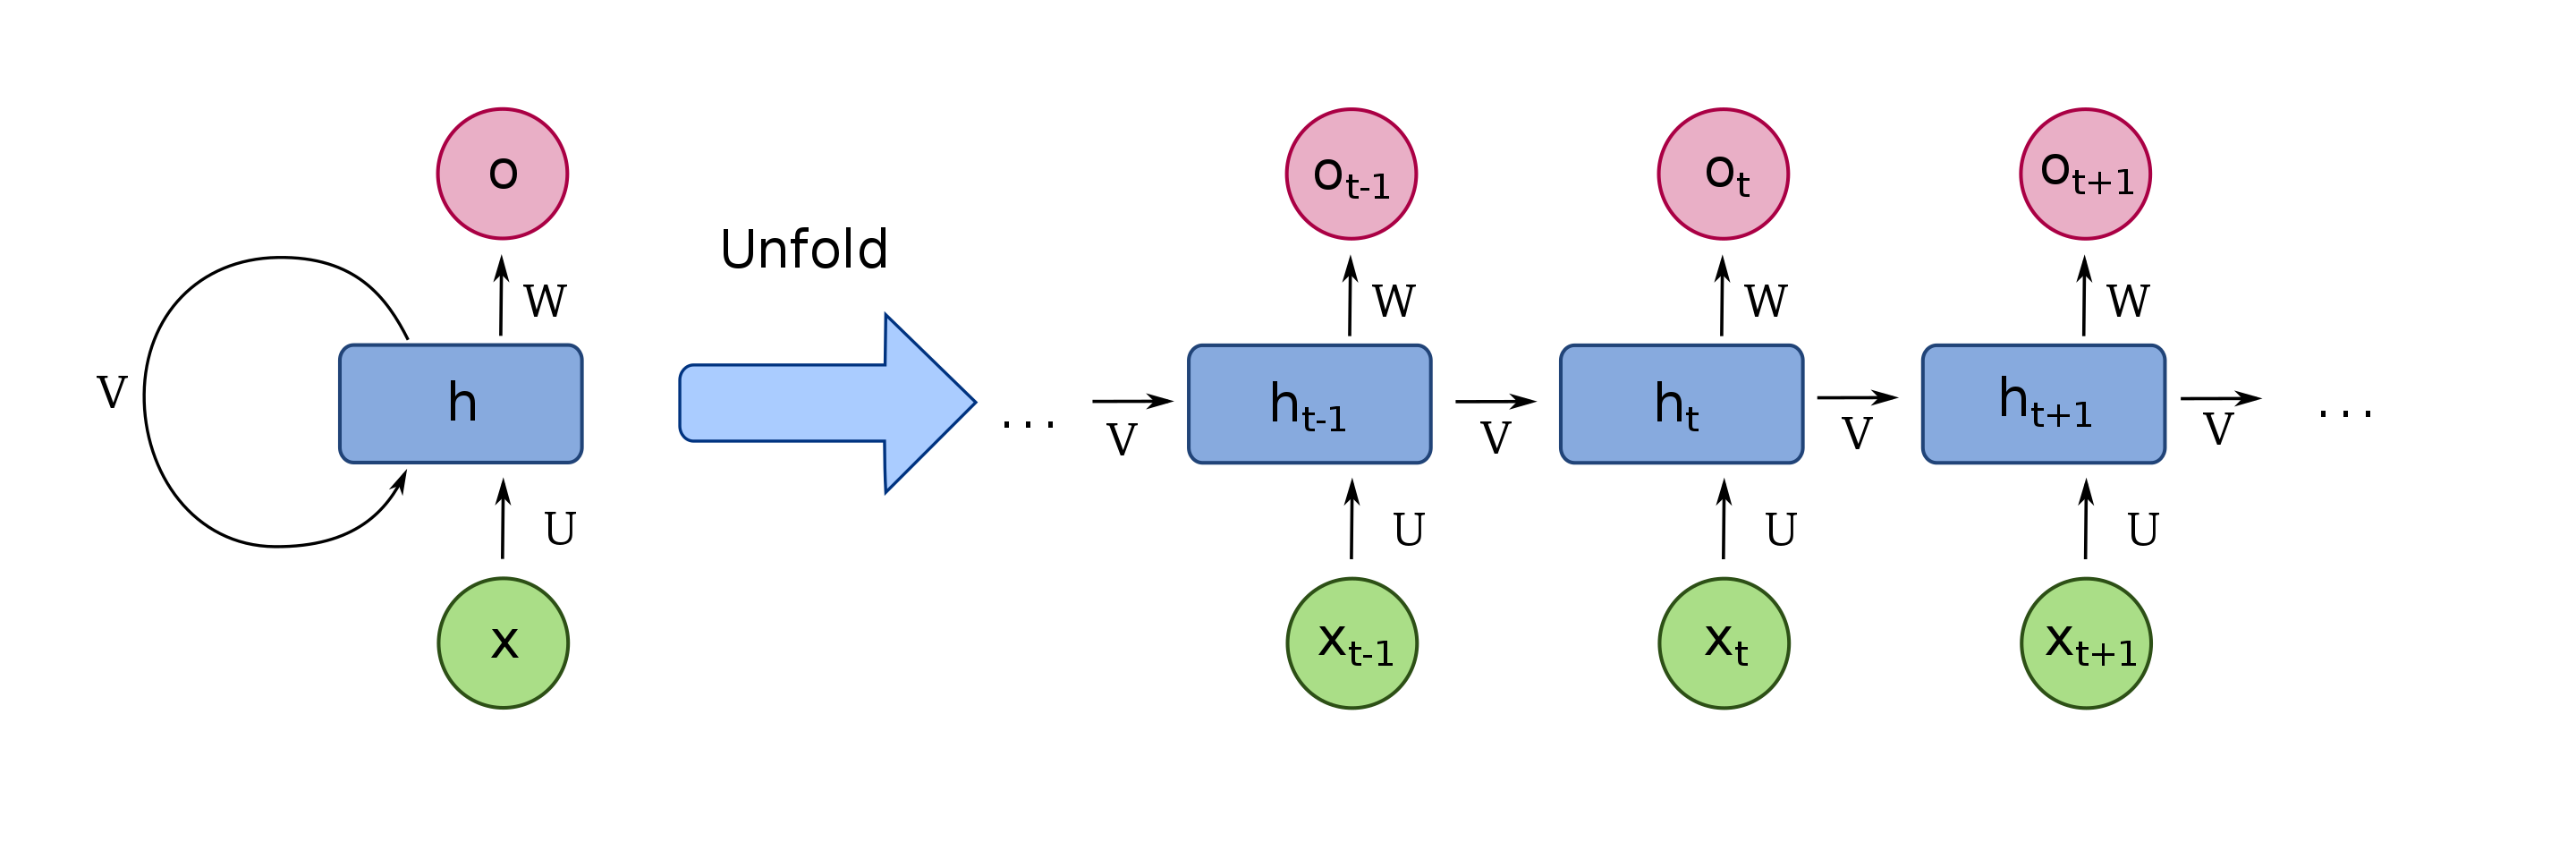

In [1]:
from IPython.display import Image
Image("RNN.png")
# Source: https://en.wikipedia.org/wiki/Recurrent_neural_network#/media/File:Recurrent_neural_network_unfold.svg
# License CC BY-SA 4.0   https://creativecommons.org/licenses/by-sa/4.0

We can download a dataset for our experiments: weather time series data collected by the [Max Planck Institute](https://www.bgc-jena.mpg.de/wetter/)

In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], "GPU")

In [2]:
from keras.utils import get_file
import pandas as pd
import numpy as np
import os

zip_path = get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline



## Let's try to build a model that is capable of predicting the temperature from previous data

Baseline model: the lazy meteorologist just predicts that tomorrow we will have the same weather as today (i.e. just use the last available data point)

We split the data into train (+ validation if needed) and test set based on the timestamps (not randomly!), we just use a 90%-10% train-test split here.

In [110]:
from sklearn.metrics import mean_squared_error


## Prediction from the previous N=20 temperature values

In [5]:
from sklearn.preprocessing import StandardScaler

N = 20

### Create another baseline model with LinearRegression

In [128]:
from sklearn.linear_model import LinearRegression



0.2089962614632902

# Recurrent neural network - LSTM

One of the best performing RNN architecture is the long short-term memory (LSTM) cell that is capable of learning long-term relations in the sequence.

- the information extracted from the sequence is stored in the cell state
- the forget gate determines how much of the previous information we want to keep/forget
- the input gate adds new information to the cell
- then we update the cell state
- finally we extract the output

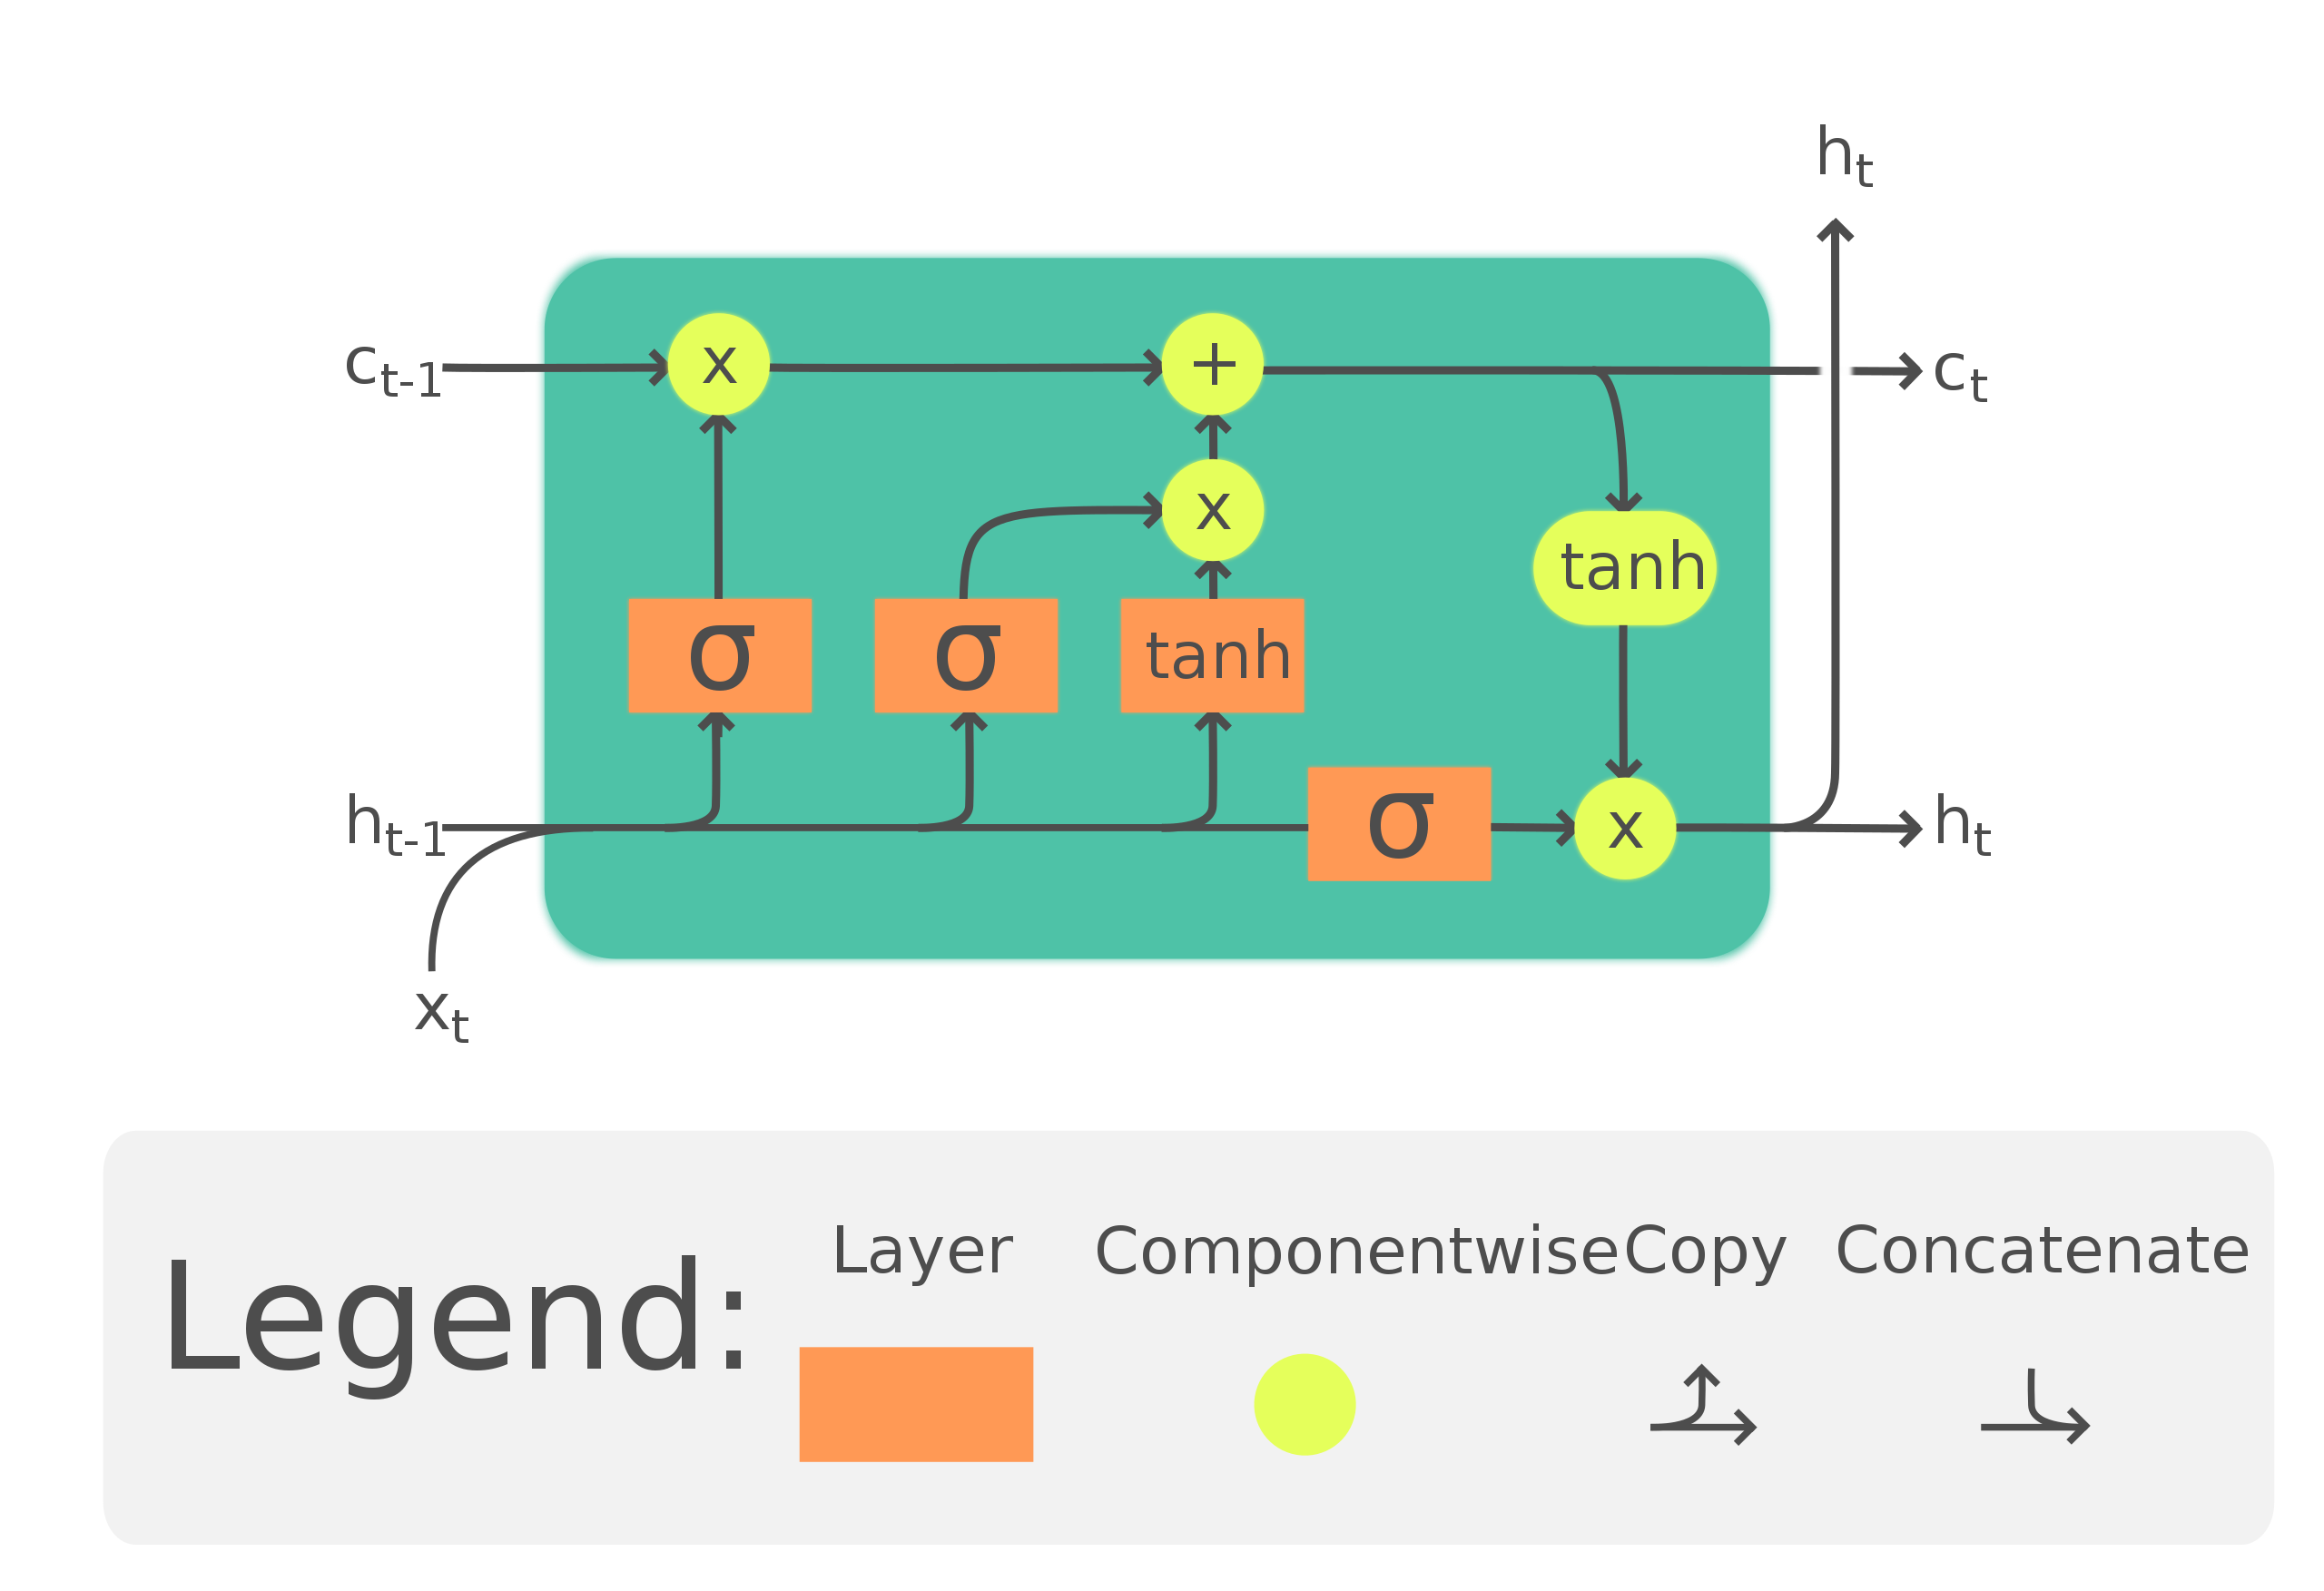

In [88]:
from IPython.display import Image
Image("LSTM.png")
# Source: https://en.wikipedia.org/wiki/Long_short-term_memory#/media/File:LSTM_Cell.svg
# License CC BY-SA 4.0   https://creativecommons.org/licenses/by-sa/4.0

Let's just build a simple RNN model with:
- a variable length input layer of shape `(None, 1)`
- an LSTM layer with 8 units
- then a fully connected Dense output layer
- use RMSprop for optimization (typically works well with RNNs)

In [6]:
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Flatten
from keras.models import Sequential, Model
from keras.utils import to_categorical
from copy import deepcopy



In [7]:
from keras.callbacks import EarlyStopping



#### Plot the predicted curve

# Text classification with RNNs

Now we switch to the classification of textual data with the [SMS Spam dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip)

In [142]:
df = pd.read_csv("SMSSpamCollection", sep="\t", names=["label", "text"])
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Let's convert every text to lowercase and normalize it (ü->u, á->a, etc.)

In [8]:
from unidecode import unidecode  # !pip install unidecode



#### Use padding with zeros for simplicity (not absolutely necessary, though)

In [9]:
maxlen = 1000



### Apply a TextVectorization on the texts that converts the texts to sequences, then we can convert them to matrices (tensors)

- `keras.layers.TextVectorization` can handle character or word-level tokenization, we can specify the
- the `adapt()` function can fit/adapt the vectorizer to the data
- access the vocabulary with `get_vocabulary()`
- we can simply apply the vectorizer on new `text` data by `vectorizer(text)`

In [11]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TextVectorization



#### Do a simple one-hot embedding of the character sequences

In [17]:
from keras.utils import to_categorical


#### Do an 80%-20% train-test split

In [13]:
from sklearn.model_selection import train_test_split


Train a Bidirectional LSTM model with
- an Input layer 
- a Bidirectional LSTM layer
- a fully connected Dense output with 1 output neuron

# Gated Recurrent Units (GRUs)

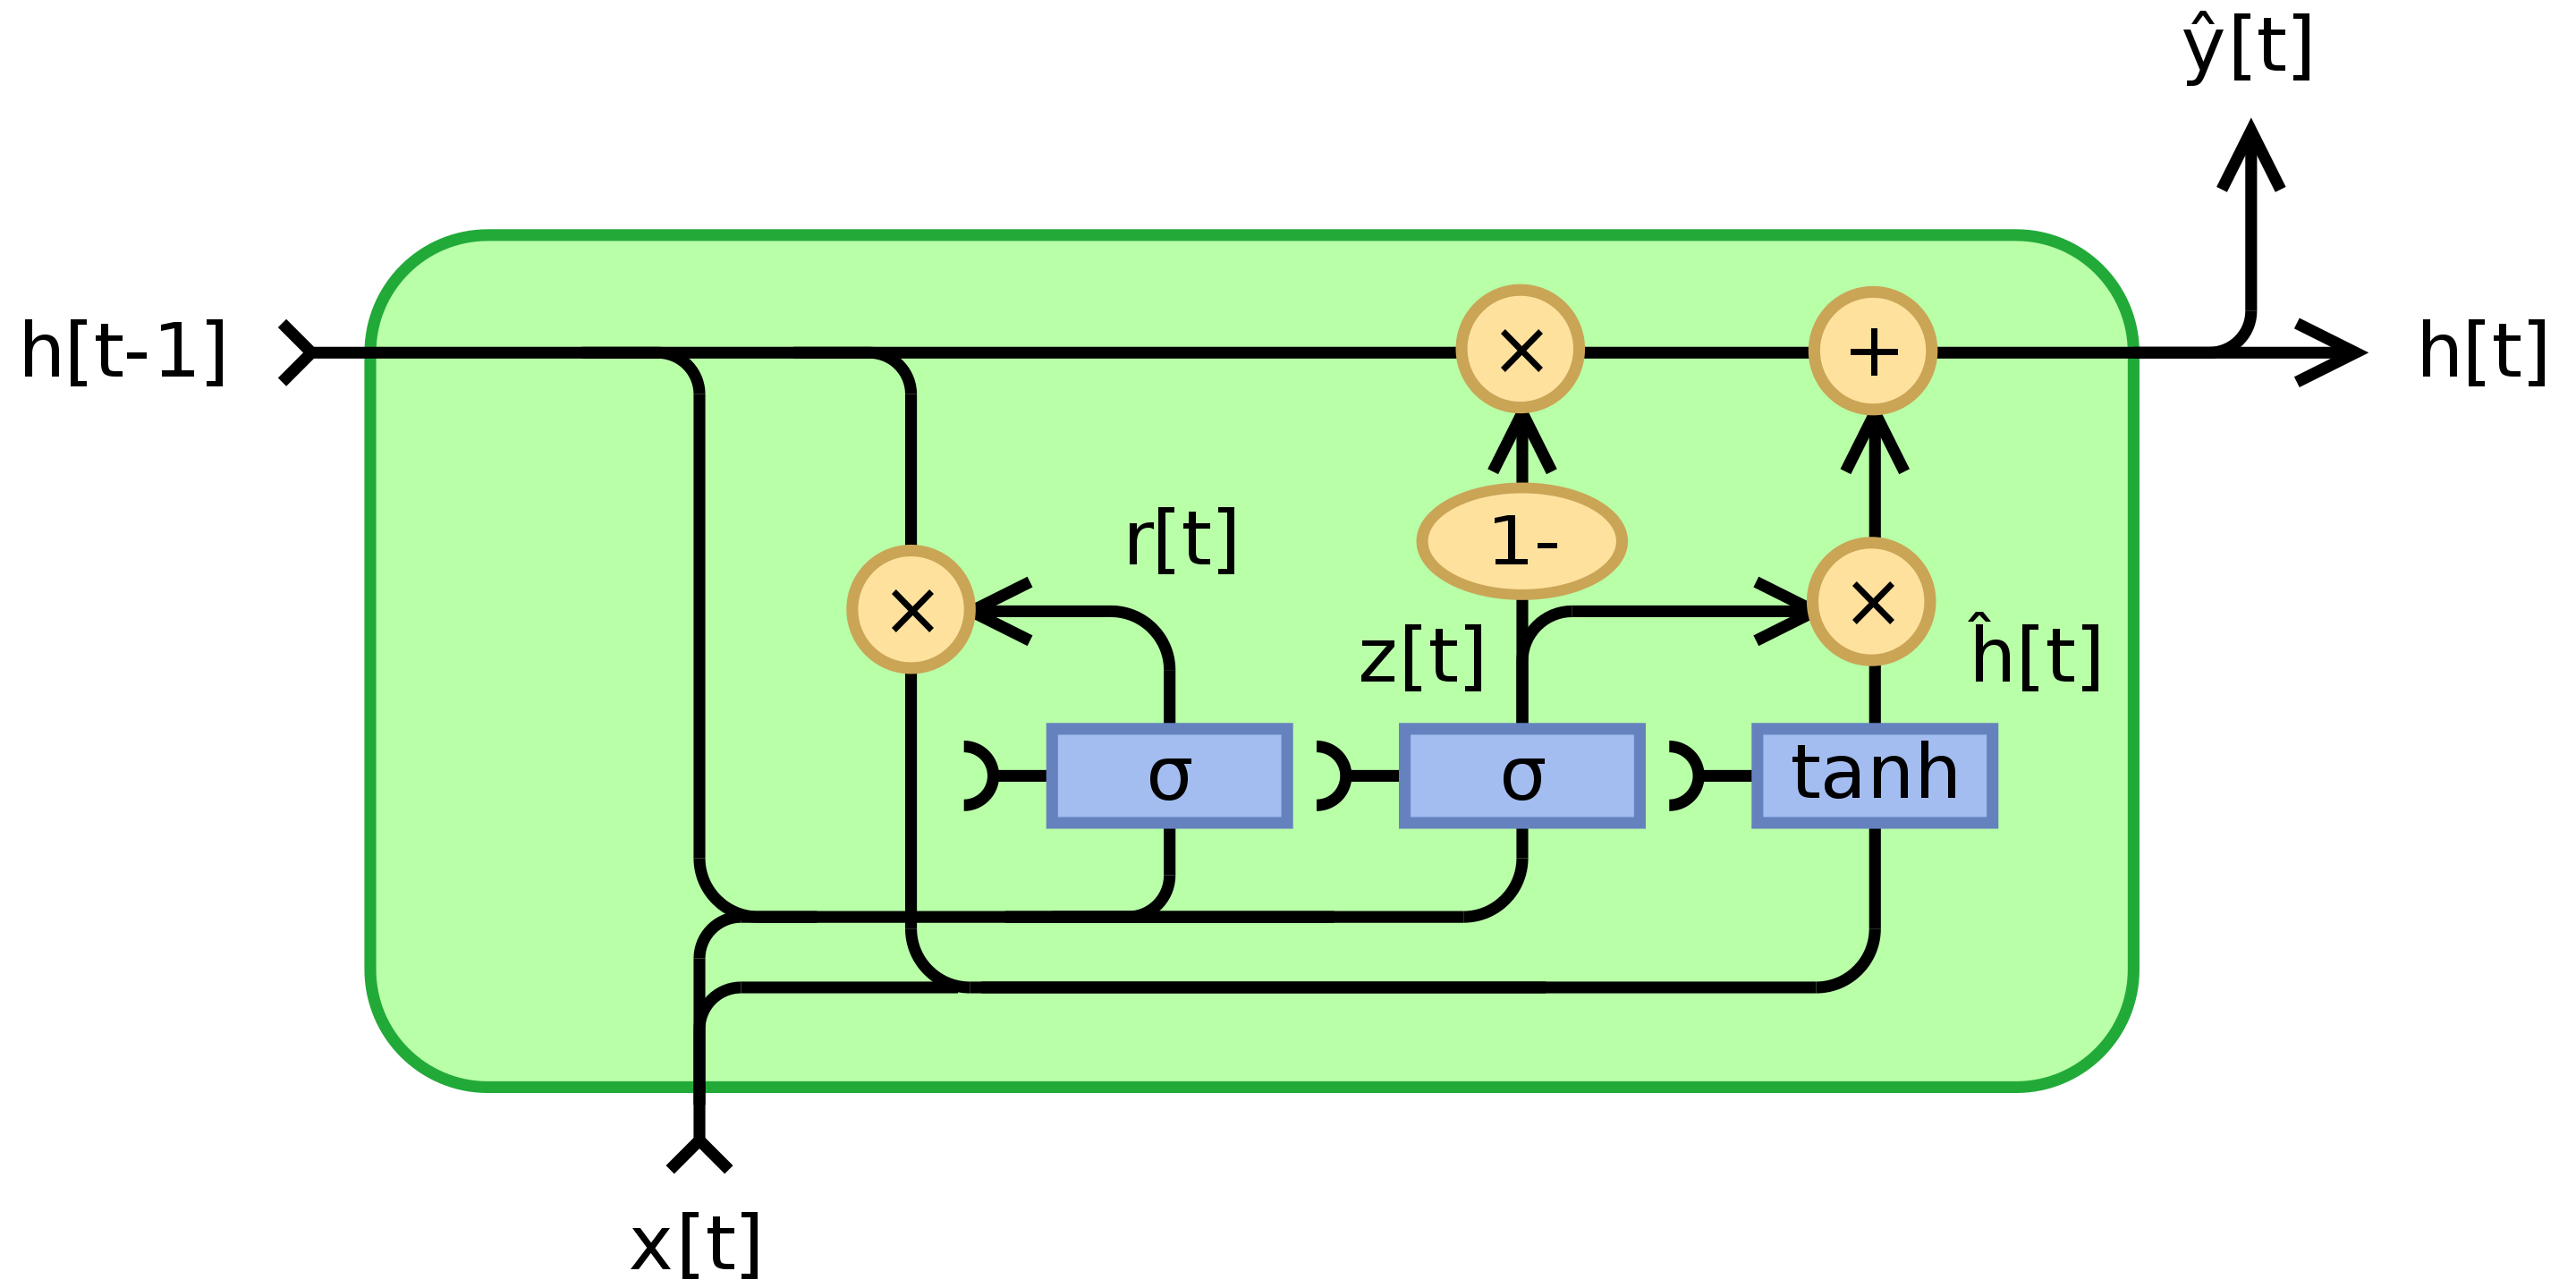

In [124]:
Image("GRU.png")
# Source: https://en.wikipedia.org/wiki/Gated_recurrent_unit#/media/File:Gated_Recurrent_Unit,_base_type.svg
# License CC BY-SA 4.0   https://creativecommons.org/licenses/by-sa/4.0

In [16]:
from keras.layers import GRU



## Stacked RNN layers

- by using `return_sequences=True` we can stack multiple LSTM/GRU layers on top of each other